# EPIC Institute of Technology
## Data Science. Homework 4

## Dear students, welcome to your data science homework assignment! Below are the tasks you need to complete. Please follow the instructions and fill in the code cells provided. Feel free do add more cells if needed.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from sklearn.pipeline import Pipeline


#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Task 1: Exploratory Data Analysis (EDA)

### 1.1 Target Distribution Analysis
- Load the dataset.
- Analyze the distribution of the target variable.

In [3]:
df = pd.read_csv('/content/train.csv')
data_test = pd.read_csv('/content/test.csv')
df

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,positive
27479,ed167662a5,But it was worth it ****.,positive


neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


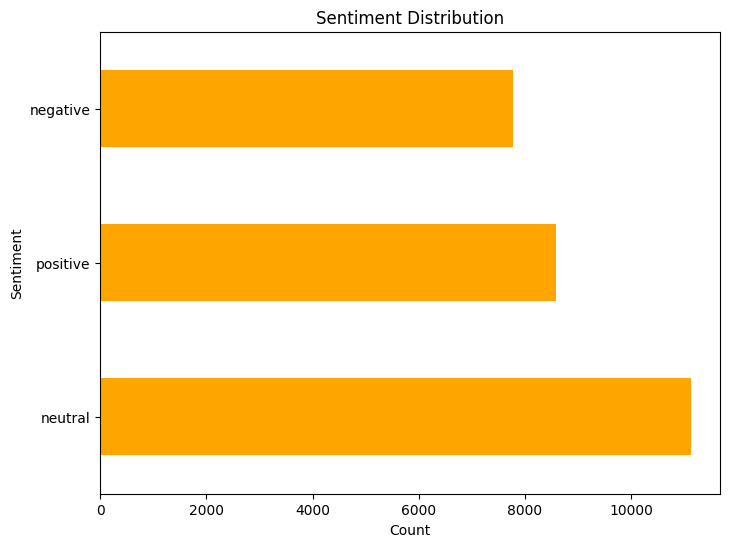

In [4]:
sentiment_distribution = df['sentiment'].value_counts()
print(sentiment_distribution)

plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='barh', color='orange')
plt.title('Sentiment Distribution')
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.show()

### 1.2 Wordclouds for Each Target
- Create wordclouds for each target.

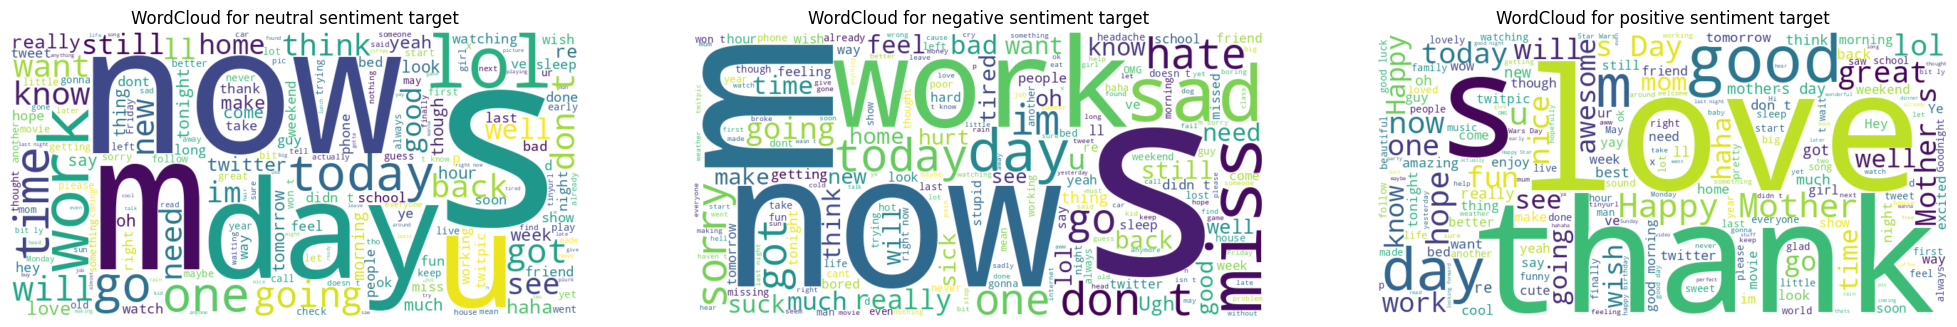

In [5]:
sentiments_target = df['sentiment'].unique()

fig, axs = plt.subplots(1, len(sentiments_target), figsize=(25, 10))

def generate_wordcloud(ax, target):
    data = df[df["sentiment"] == target]
    text_data = ' '.join(str(item) for item in data.text)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'WordCloud for {target} sentiment target')

for i, sentiment in enumerate(sentiments_target):
    generate_wordcloud(axs[i], sentiment)

plt.show()


### 1.3 Analysis of Most Common Words for Each Target
- Analyze and visualize the most common words for each target.

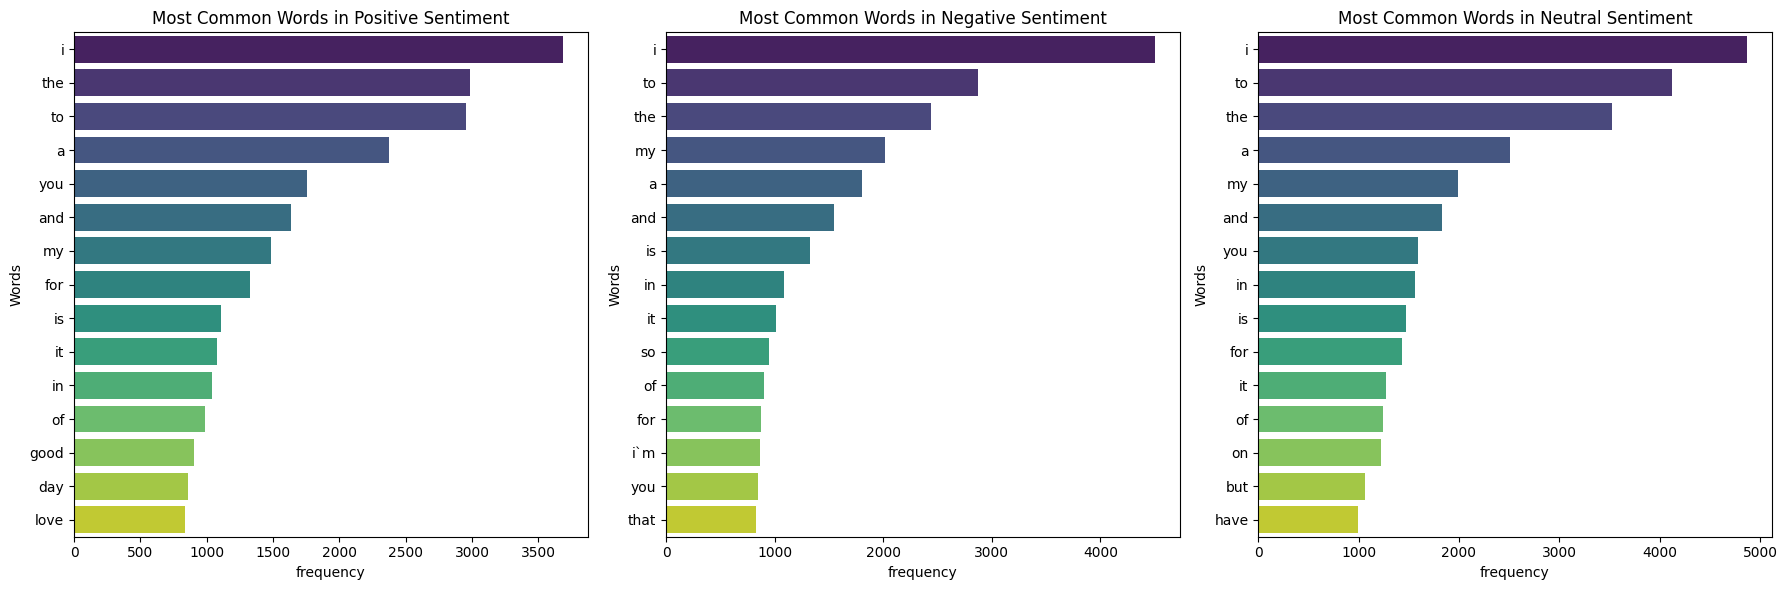

In [19]:
#----------------NOTE----------------#
# run preprocess_text function first in task 2.1 to add clean_text colmun

df['text'].fillna('', inplace=True)

if 'clean_text' in df.columns:
  positive_words = df[df['sentiment'] == 'positive']['clean_text'].apply(lambda x: [word.lower() for word in x.split()])
  negative_words = df[df['sentiment'] == 'negative']['clean_text'].apply(lambda x: [word.lower() for word in x.split()])
  neutral_words = df[df['sentiment'] == 'neutral']['clean_text'].apply(lambda x: [word.lower() for word in x.split()])
else:
  positive_words = df[df['sentiment'] == 'positive']['text'].apply(lambda x: [word.lower() for word in x.split()])
  negative_words = df[df['sentiment'] == 'negative']['text'].apply(lambda x: [word.lower() for word in x.split()])
  neutral_words = df[df['sentiment'] == 'neutral']['text'].apply(lambda x: [word.lower() for word in x.split()])

sentiments = {'positive': positive_words, 'negative': negative_words, 'neutral': neutral_words}

def plot_word_frequency(ax, word_counter, title):
    common_words = [word[0] for word in word_counter.most_common(15)]
    counts = [word[1] for word in word_counter.most_common(15)]

    sns.barplot(x=counts, y=common_words, palette="viridis", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("frequency")
    ax.set_ylabel("Words")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (sentiment, words) in enumerate(sentiments.items()):
    word_counter = Counter()
    for word_list in words:
        word_counter.update(word_list)

    plot_word_frequency(axes[i], word_counter, f'Most Common Words in {sentiment.capitalize()} Sentiment')

plt.tight_layout()
plt.show()

### 1.4 Other Plots (Optional)
- Generate any additional plots that you think might provide valuable insights into the data.

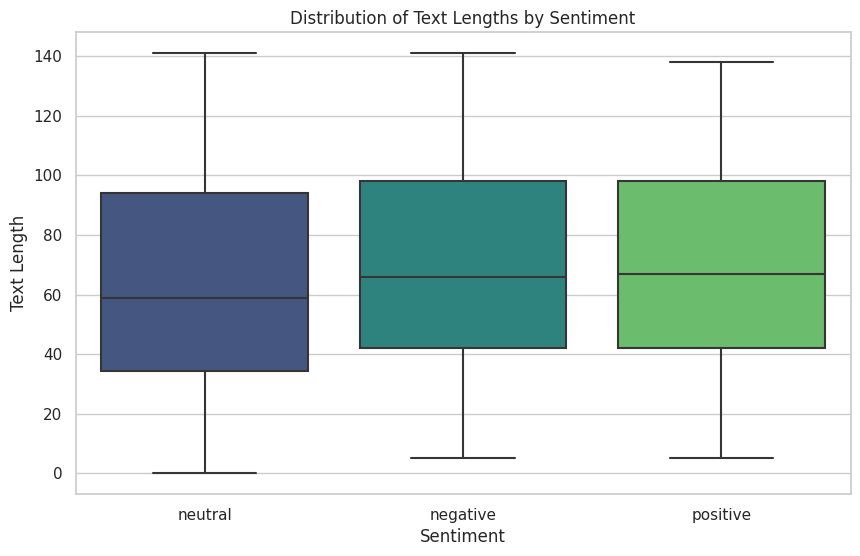

In [21]:
df['text_len'] = df.text.apply(len)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='text_len', data=df, palette='viridis')
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()


## Task 2: Feature Engineering

### 2.1 Text Preprocessing
- Remove punctuation, default stop words, and stop words not covered by default.

In [30]:

def handle_negations(words):
    negation_words = set(["not", "no", "never", "none", "nobody", "nowhere", "nothing", "neither", "nor"])
    negation_flag = False
    negated_words = []

    for word in words:
        if word in negation_words:
            negation_flag = not negation_flag
        else:
            if negation_flag:
                word = "not_" + word
            negated_words.append(word)

    return negated_words


def preprocess_text(text, additional_stopwords=None):
    if pd.notna(text):
        text = re.sub(r'\d+', '', text)

        # Remove punctuation
        nopunc = text.translate(str.maketrans("", "", string.punctuation))

        words = word_tokenize(nopunc)
        words = [word.lower() for word in words]

        # default stop words, and stop words not covered by default
        stop_words = set(stopwords.words('english') + additional_stopwords)
        words = [word for word in words if word.lower() not in stop_words]

        words = handle_negations(words)

        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        processed_text = " ".join(words)
    else:
        processed_text = ""

    return processed_text

additional_stopwords = ['http','u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x, additional_stopwords))
data_test['clean_text'] = data_test['text'].apply(lambda x: preprocess_text(x, additional_stopwords))

df

,textID,text,sentiment,text_len,clean_text,numerical_sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral,36,id responded going,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,46,sooo sad miss san diego,-1
2,088c60f138,my boss is bullying me...,negative,25,bos bullying,-1
3,9642c003ef,what interview! leave me alone,negative,31,interview leave alone,-1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,75,son couldnt put release already bought,-1
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,negative,77,wish could come see denver husband lost job ca...,-1
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,negative,122,ive wondered rake client made clear net force ...,-1
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,positive,111,yay good enjoy break probably need hectic week...,1
27479,ed167662a5,But it was worth it ****.,positive,27,worth,1


### 2.2 Generate Features
- Choose one of the following methods: TF IDF, Counter, or binary feature for each word (whether you have such a word in your text).
- Generate features and update your dataset.

In [31]:
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

vect = CountVectorizer(ngram_range=(1, 3))
vect.fit(X_train)

X_train_dtm = vect.transform(X_train)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<20610x221776 sparse matrix of type '<class 'numpy.float64'>'
	with 366955 stored elements in Compressed Sparse Row format>

## Task 3: Model Fitting

### 3.1 Fitting NaiveBayes
- Fit a Naive Bayes model to the data.

In [39]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

y_pred = nb.predict(X_test_dtm)

nb_accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes accuracy:: {nb_accuracy}")

Naive Bayes accuracy:: 0.6469218454373453


### 3.2 Fitting SVC
- Fit a Support Vector Classifier (SVC) to the data.

In [40]:
svc = LinearSVC()
svc.fit(X_train_dtm, y_train)

y_pred = svc.predict(X_test_dtm)

svc_accuracy = accuracy_score(y_test, y_pred)
print("SVC accuracy:", svc_accuracy)

SVC accuracy: 0.6873817493814584


### 3.3 Fitting Decision Tree
- Fit a Decision Tree model to the data.

In [38]:
dt = DecisionTreeClassifier()
dt.fit(X_train_dtm, y_train)

y_pred = dt.predict(X_test_dtm)

dt_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy:", dt_accuracy)

Decision Tree accuracy: 0.6694804249745306


### 3.4 Model Comparison and Hyperparameter Tuning
- Compare the performance of the three models.
- Perform cross-validation and grid search to find the best hyperparameters for each model.

In [45]:
param_grid = {'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train_dtm, y_train)

best_params = grid_search.best_params_
logregG = LogisticRegression(solver='liblinear', C= best_params['C'], penalty= best_params['penalty'])

%time logregG.fit(X_train_dtm, y_train)
y_pred = logregG.predict(X_test_dtm)

y_pred_prob1 = logregG.predict_proba(X_test_dtm)[:, 1]
print(y_pred_prob1)

LRG_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", LRG_accuracy)

CPU times: user 1.41 s, sys: 15 ms, total: 1.42 s
Wall time: 1.42 s
[0.36213409 0.7981273  0.78569821 ... 0.10475513 0.18876624 0.58197441]
Accuracy: 0.7079027797991558


In [43]:

logregCS = LogisticRegression(solver='liblinear')
cv = cross_val_score(logregCS, X_train_dtm, y_train, cv=5)

print("Mean Accuracy:", cv.mean())

logregCS.fit(X_train_dtm, y_train)
y_pred = logregCS.predict(X_test_dtm)
y_pred_prob2 = logregCS.predict_proba(X_test_dtm)[:, 1]

print(y_pred_prob2)
LRCS_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", LRCS_accuracy)


Mean Accuracy: 0.6823386705482775
[0.33132881 0.86368904 0.68125582 ... 0.0935032  0.30642509 0.62422645]
Accuracy: 0.6990248872071023


In [ ]:
ids = data_test['textID']
predictions = logregG.predict(vect.transform(data_test['clean_text']))

output = pd.DataFrame({'textID': ids, 'sentiment': predictions})
output.to_csv('predictions.csv', index=False)
output.head()

,textID,sentiment
0,f87dea47db,neutral
1,96d74cb729,positive
2,eee518ae67,neutral
3,01082688c6,positive
4,33987a8ee5,neutral


## Task 4: Kaggle Submission

### Submit your predictions to Kaggle and compete with other students!
Don't forget to leave a link to your Kaggle profile so that we can identify your work.
<br>
GL & HF 😉

[Lama Salah - Kaggle profile](https://www.kaggle.com/lamasalah)